![logo](../imgs/MLU_Logo.png)

---

# TrainDeployTest Model

This notebook is about executing all the steps of the Machine Learning development pipeline, using some features SageMaker offers. We'll use a public dataset called iris. Iris is a toy dataset and this is a very simple example. The idea here is to focus on the SageMaker features to see how SageMaker can accelerate your work and avoid wasting your time with tasks that aren't related to your business. 

SageMaker library 2.0+ is required!

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import boto3

import sagemaker
from sagemaker.serializers import CSVSerializer
from sagemaker import get_execution_role

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import datasets

sns.set(color_codes=True)

## Importing the Dataset
Let's  start by importing the dataset and visualize it!

In [1]:
iris = datasets.load_iris()

X=iris.data
y=iris.target

dataset = np.insert(iris.data, 0, iris.target,axis=1)

df = pd.DataFrame(data=dataset, columns=['iris_id'] + iris.feature_names)
df['species'] = df['iris_id'].map(lambda x: 'setosa' if x == 0 else 'versicolor' if x == 1 else 'virginica')

df.head()

,iris_id,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,0.0,5.1,3.5,1.4,0.2,setosa
1,0.0,4.9,3.0,1.4,0.2,setosa
2,0.0,4.7,3.2,1.3,0.2,setosa
3,0.0,4.6,3.1,1.5,0.2,setosa
4,0.0,5.0,3.6,1.4,0.2,setosa


In [2]:
df.describe()

,iris_id,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,1.000000,5.843333,3.057333,3.758000,1.199333
std,0.819232,0.828066,0.435866,1.765298,0.762238
min,0.000000,4.300000,2.000000,1.000000,0.100000
25%,0.000000,5.100000,2.800000,1.600000,0.300000
50%,1.000000,5.800000,3.000000,4.350000,1.300000
75%,2.000000,6.400000,3.300000,5.100000,1.800000
max,2.000000,7.900000,4.400000,6.900000,2.500000


### Checking the Class Distribution

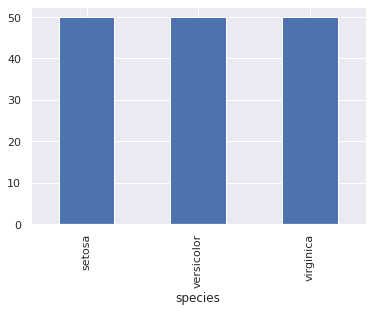

In [21]:
df.groupby(df['species'])['species'].count().plot(kind='bar');

### Correlation Matrix

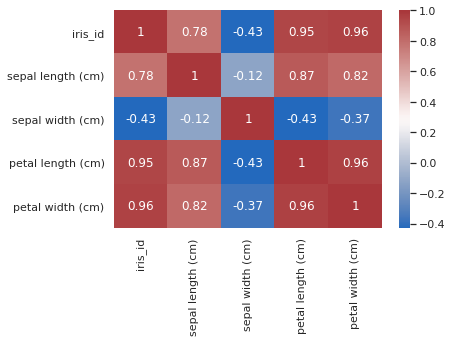

In [31]:
sns.heatmap(df.corr(), annot=True, cmap = 'vlag',
            xticklabels=df.corr().columns.values,
            yticklabels=df.corr().columns.values,
            );

### Pairplots & Histograms

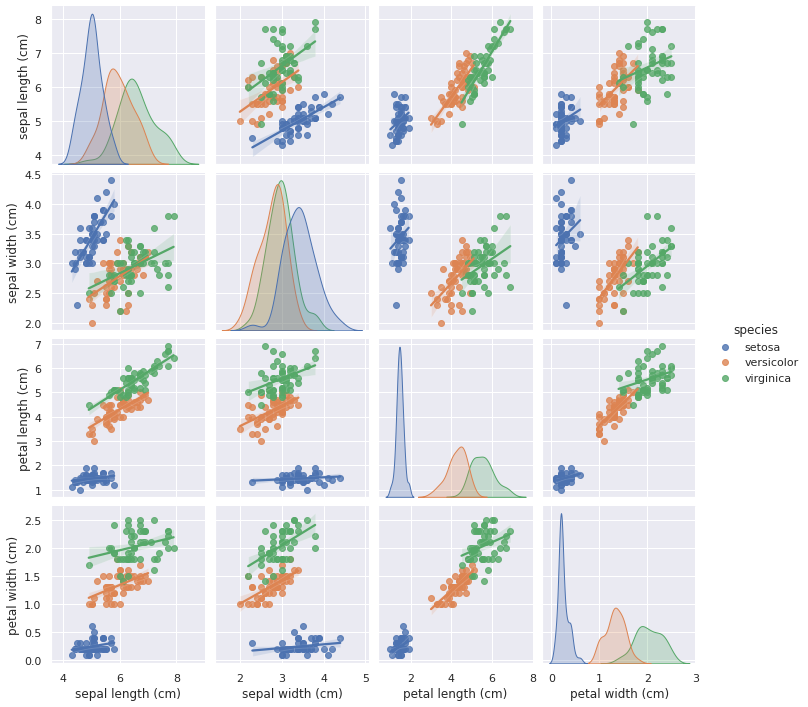

In [6]:
sns.pairplot(df.drop(['iris_id'], axis=1), kind="reg", hue='species', height=2.5,diag_kind="kde")

Petal length and petal width have the highest linear correlation with our label. Also, sepal width seems to be useless, considering the linear correlation with our label.

## Train an XGBoost Model

First, let's split the dataset into training and test.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
yX_train = np.column_stack((y_train, X_train))
yX_test = np.column_stack((y_test, X_test))

# Save labels & features to CSV
np.savetxt("iris_train.csv", yX_train, delimiter=",", fmt='%0.3f')
np.savetxt("iris_test.csv", yX_test, delimiter=",", fmt='%0.3f')

We will initialize the builtin algorithm XGBoost.

In [9]:
role = get_execution_role()

prefix='mlops/iris'

# Retrieve the default bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
assert(sagemaker.__version__ >= "2.0")

Now we upload the dataset and train the model.

In [10]:
# Upload the dataset to an S3 bucket
input_train = sagemaker_session.upload_data(path='iris_train.csv', key_prefix='%s/data' % prefix)
input_test = sagemaker_session.upload_data(path='iris_test.csv', key_prefix='%s/data' % prefix)

In [11]:
# Configure training data
train_data = sagemaker.inputs.TrainingInput(s3_data=input_train,content_type="csv")
test_data = sagemaker.inputs.TrainingInput(s3_data=input_test,content_type="csv")

In [12]:
# Get the URI for new container
container_uri = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, version='1.0-1')

# Create the estimator
xgb = sagemaker.estimator.Estimator(container_uri,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker_session)
# Set the hyperparameters
xgb.set_hyperparameters(eta=0.1,
                        max_depth=10,
                        gamma=4,
                        num_class=len(np.unique(y)),
                        alpha=10,
                        min_child_weight=6,
                        silent=0,
                        objective='multi:softmax',
                        num_round=30)

It is time for training!

(Note: the training will take roughly **~5 minutes**.)

In [13]:
%%time
# takes around 3min 11s
xgb.fit({'train': train_data, 'validation': test_data,})

2022-04-04 01:09:38 Starting - Starting the training job...ProfilerReport-1649034578: InProgress
...
2022-04-04 01:10:22 Starting - Preparing the instances for training......
2022-04-04 01:11:26 Downloading - Downloading input data...
2022-04-04 01:12:07 Training - Downloading the training image......
2022-04-04 01:13:03 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[01:13:08] 100x4 matrix with 400 entries loaded from /opt/ml/input/data/train?format=csv&lab

## Deploy to the Endpoint

Let's deploy the model and create an endpoint for it. The following action will:
 * get the assets from the job we just ran and then create an input in the Models Catalog
 * create a endpoint configuration (a metadata for our final endpoint)
 * create an endpoint, which is our model wrapped in a format of a WebService
 
After that we'll be able to call our deployed endpoint for doing predictions.

(Note: The follow deployment cell may run around **~10 minutes**. You can find your endpoint at [Sagemaker Endpoints](https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/endpoints).)


In [14]:
%%time
# Enable log capturing in the endpoint
data_capture_configuration = sagemaker.model_monitor.data_capture_config.DataCaptureConfig(
    enable_capture=True, 
    sampling_percentage=100, 
    destination_s3_uri='s3://{}/{}/monitoring'.format(bucket, prefix), 
    sagemaker_session=sagemaker_session
)
xgb_predictor = xgb.deploy(
    initial_instance_count=1, 
    instance_type= 'ml.m5.xlarge', ## 'ml.t3.medium'
    data_capture_config=data_capture_configuration
)

-------------!CPU times: user 215 ms, sys: 6.62 ms, total: 221 ms
Wall time: 6min 31s


## Setup Monitor

Alright, now that we have deployed the endpoint, with data capturing enabled, it's time to setup the monitor.
Let's start by configuring our predictor:

In [15]:
# Retrieve endpoint name from deployed predictor
endpoint_name = xgb_predictor.endpoint_name

# Describe endpoint (create endpoint config)
model_name = boto3.client('sagemaker').describe_endpoint_config(
    EndpointConfigName=endpoint_name)['ProductionVariants'][0]['ModelName']

# Save model name to txt file
!echo $model_name > model_name.txt

# Save endpoint name to txt file
!echo $endpoint_name > endpoint_name.txt

# Specify format predictor accepts as input
csv_serializer = CSVSerializer()
xgb_predictor.serializer = csv_serializer

## Test the Endpoint

Now, let's do a basic test with the deployed endpoint. We'll use a helper object called **predict**. This object is always returned from a **Deploy** call. The predictor is just for testing purposes and we'll **NOT** use it inside our real application.

In [16]:
predictions_test = [ float(xgb_predictor.predict(x).decode('utf-8')) for x in X_test] 
score = f1_score(y_test,predictions_test,labels=[0.0,1.0,2.0],average='micro')

print('F1 Score(micro): %.1f' % (score * 100.0))

F1 Score(micro): 90.0


## Test the API

Then, let's  test the API for our trained model. Using `boto3` for getting a sagemaker runtime client and then we'll call invoke_endpoint

In [17]:
from sagemaker.serializers import CSVSerializer
csv_serializer = CSVSerializer()

sm = boto3.client('sagemaker-runtime')
resp = sm.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='text/csv',
    Body=csv_serializer.serialize(X_test[0])
)
prediction = float(resp['Body'].read().decode('utf-8'))
print('Predicted class: %.1f for [%s]' % (prediction, csv_serializer.serialize(X_test[0])) )

Predicted class: 1.0 for [6.3,2.8,5.1,1.5]
